In [30]:
from google.cloud import vision
from google.cloud import storage
from PIL import Image
import numpy as np
import os, sys
import csv  
from io import BytesIO
from IPython import display
import csv
from tempfile import NamedTemporaryFile
import shutil
import cv2

# Our scripts
from corrections import *
from image import * 
from handling import *

os.environ["GOOGLE_APPLICATION_CREDENTIALS"] = r"../guppies-test-4c48569421d8.json"

### Read all files from the google bucket. Can cycle through the files in this list and write results to the csv file.

In [22]:
all_files = ListAvaliableFiles("guppy_images")
all_jpg_files = [ x for x in all_files if "JPG" in x ]

new_files = ListAvaliableFiles("guppy_images", "Manually_Labelled/New")
new_jpg_files = [ x for x in new_files if "JPG" in x ]
print(len(all_jpg_files), len(new_jpg_files))

122927 98438


### Reanalyse and check the accuracy of the algorithm

In [3]:
ReanalysePredictions("../Data/Truth.csv", verbose=True)
correct_files, incorrect_files, invalid_files, character_confusions = \
    AccuracyCheck("/Users/jordan/Desktop/Guppies/Data/Truth.csv", verbose=False)

Reanalysed predictions

Number Correct: 728 
Number Incorrect: 223 
Number Invalid: 49
Attempted % Correct: 0.7655099894847529
Total % Correct: 0.728


### Opens a file from the google bucket (or locally), crops it, reads it and corrects the output.


Image has been read from google bucket.

Image has been cropped.

Initial label: MUL-1570-002/04/13 
Confidence: 0.7680219636438964

Removing special characters from the output string (e.g. '.', '|').
characters ( have been replaced with 1
characters \ have been replaced with 1
characters ( have been replaced with 1
characters \ have been replaced with 1
Character M is fine.
Character U is fine.
Character L is fine.
Character - is fine.
Character 1 is fine.
Character 5 is fine.
Character 7 is fine.
Character 0 is fine.
Character - is fine.
Character 0 is fine.
Character 0 is fine.
Character 2 is fine.
Character / is fine.
Character 0 is fine.
Character 4 is fine.
Character / is fine.
Character 1 is fine.
Character 3 is fine.

Preprocessing string.
String after preprocessing: ['MUL', '1570', '002/04/13']

Correct number of paragraphs.

Looking for errors in the title (MUL).
Final title: MUL

Looking for errors in the identity (1570).
Replacing erroneous number (5) with a matched altern

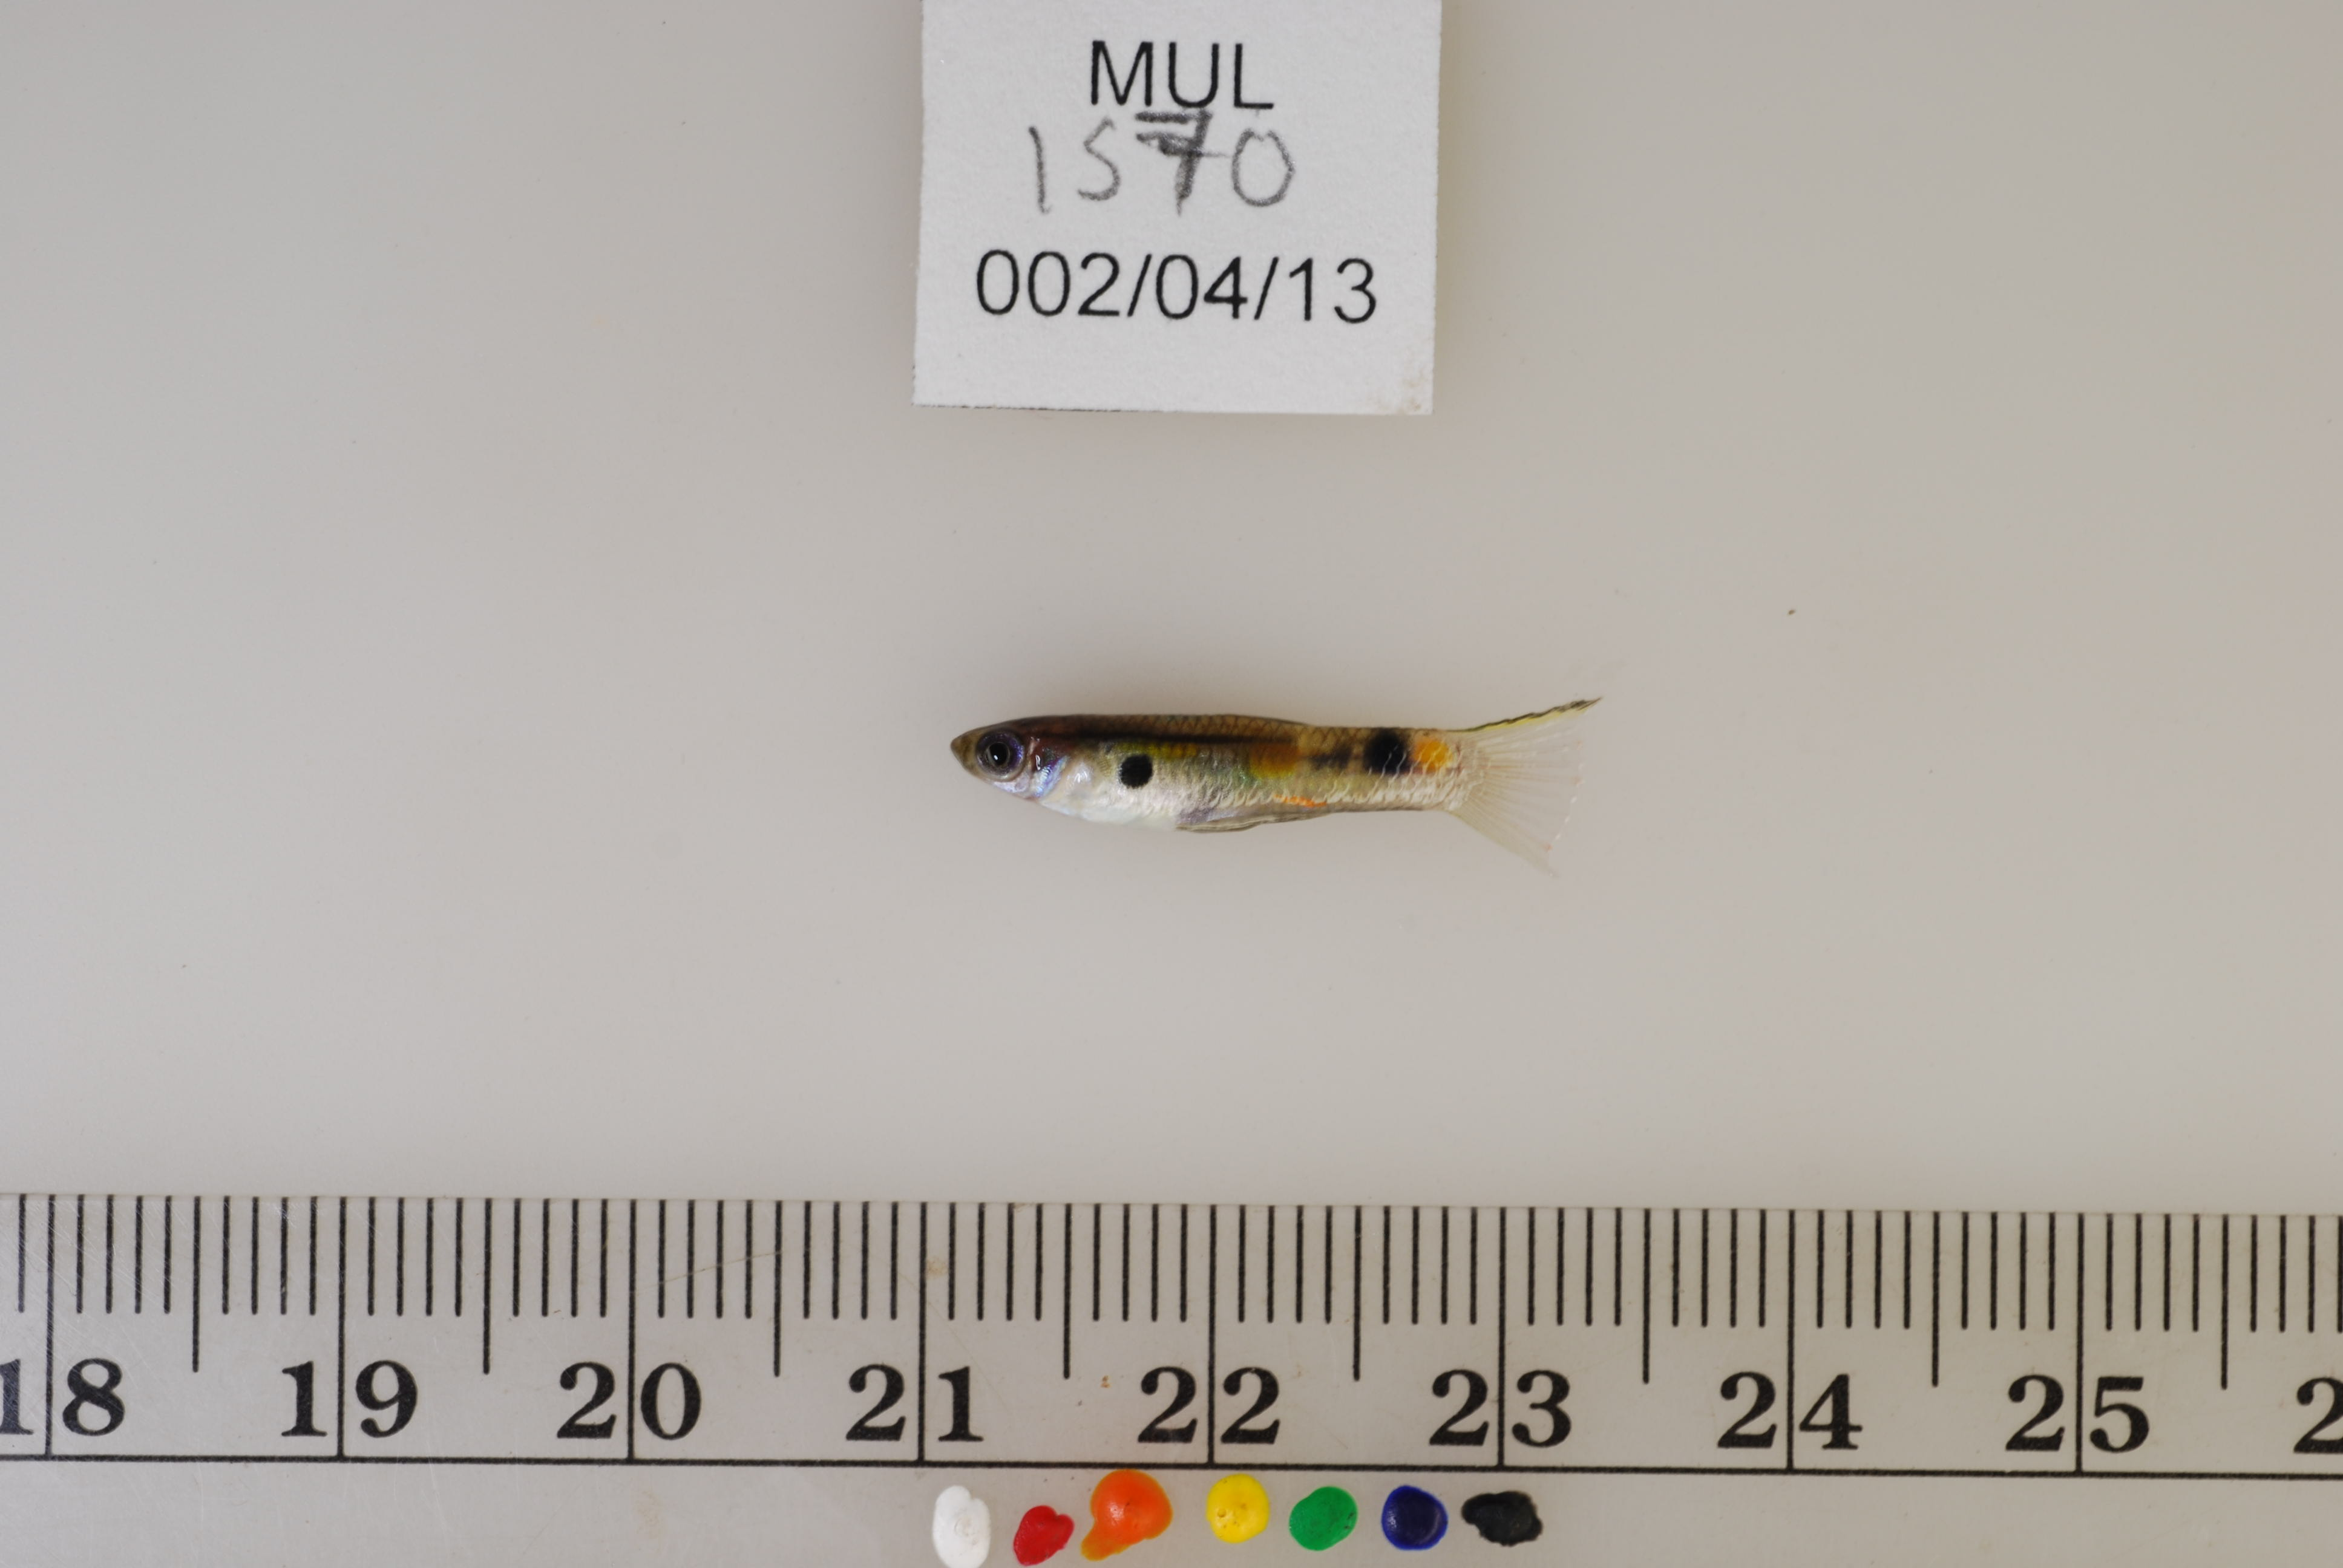

In [4]:
image, initial_label, corrected_label, word_confidences = \
    CorrectedLabel(correct_files[105], "remote", verbose=True)

Image.open(image)

### Make the confusion matrix

Text(0, 0.5, 'True Character')

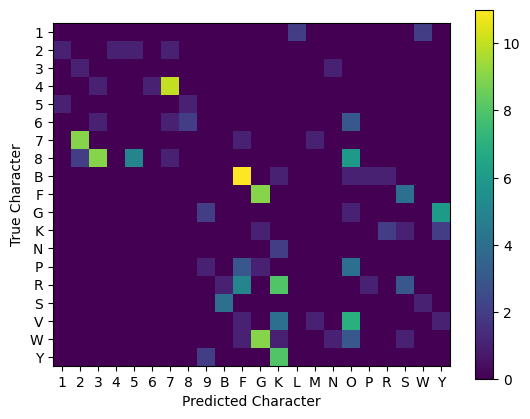

In [7]:
true_chars_unique, pred_chars_unique, confusion_matrix = \
    ConfusionMatrix(character_confusions)

import matplotlib.pyplot as plt
plt.imshow(confusion_matrix)
plt.yticks(np.arange(len(true_chars_unique)), true_chars_unique)
plt.xticks(np.arange(len(pred_chars_unique)), pred_chars_unique)
plt.colorbar()
plt.xlabel("Predicted Character")
plt.ylabel("True Character")

### Only need character_confusions to recover the confusion matrix. Save character confusions to be read directly by the code.

In [9]:
np.save('../Data/character_confusions.npy', character_confusions)


Image has been read from google bucket.

Image has been cropped.

Initial label: 1/24/10-DTOI-773 
Confidence: 0.1868559150320557

Removing special characters from the output string (e.g. '.', '|').
Character 1 is fine.
Character / is fine.
Character 2 is fine.
Character 4 is fine.
Character / is fine.
Character 1 is fine.
Character 0 is fine.
Character - is fine.
Character D is fine.
Character T is fine.
Character O is fine.
Character I is fine.
Character - is fine.
Character 7 is fine.
Character 7 is fine.
Character 3 is fine.

Preprocessing string.
Dropping 1 as label does not begin with 'M' or 'F'.
Title is the incorrect length. Using only the first three (3) characters.
String after preprocessing: ['DTO', '', 'DTO']

Correct number of paragraphs.

Looking for errors in the title (DTO).
Final title: DTO

Looking for errors in the identity ().
Incorrect identity length. Identity has 0 elements, must be more than four (4).

Incorrectly labelled the identity.

Initial label: 1/24/10-

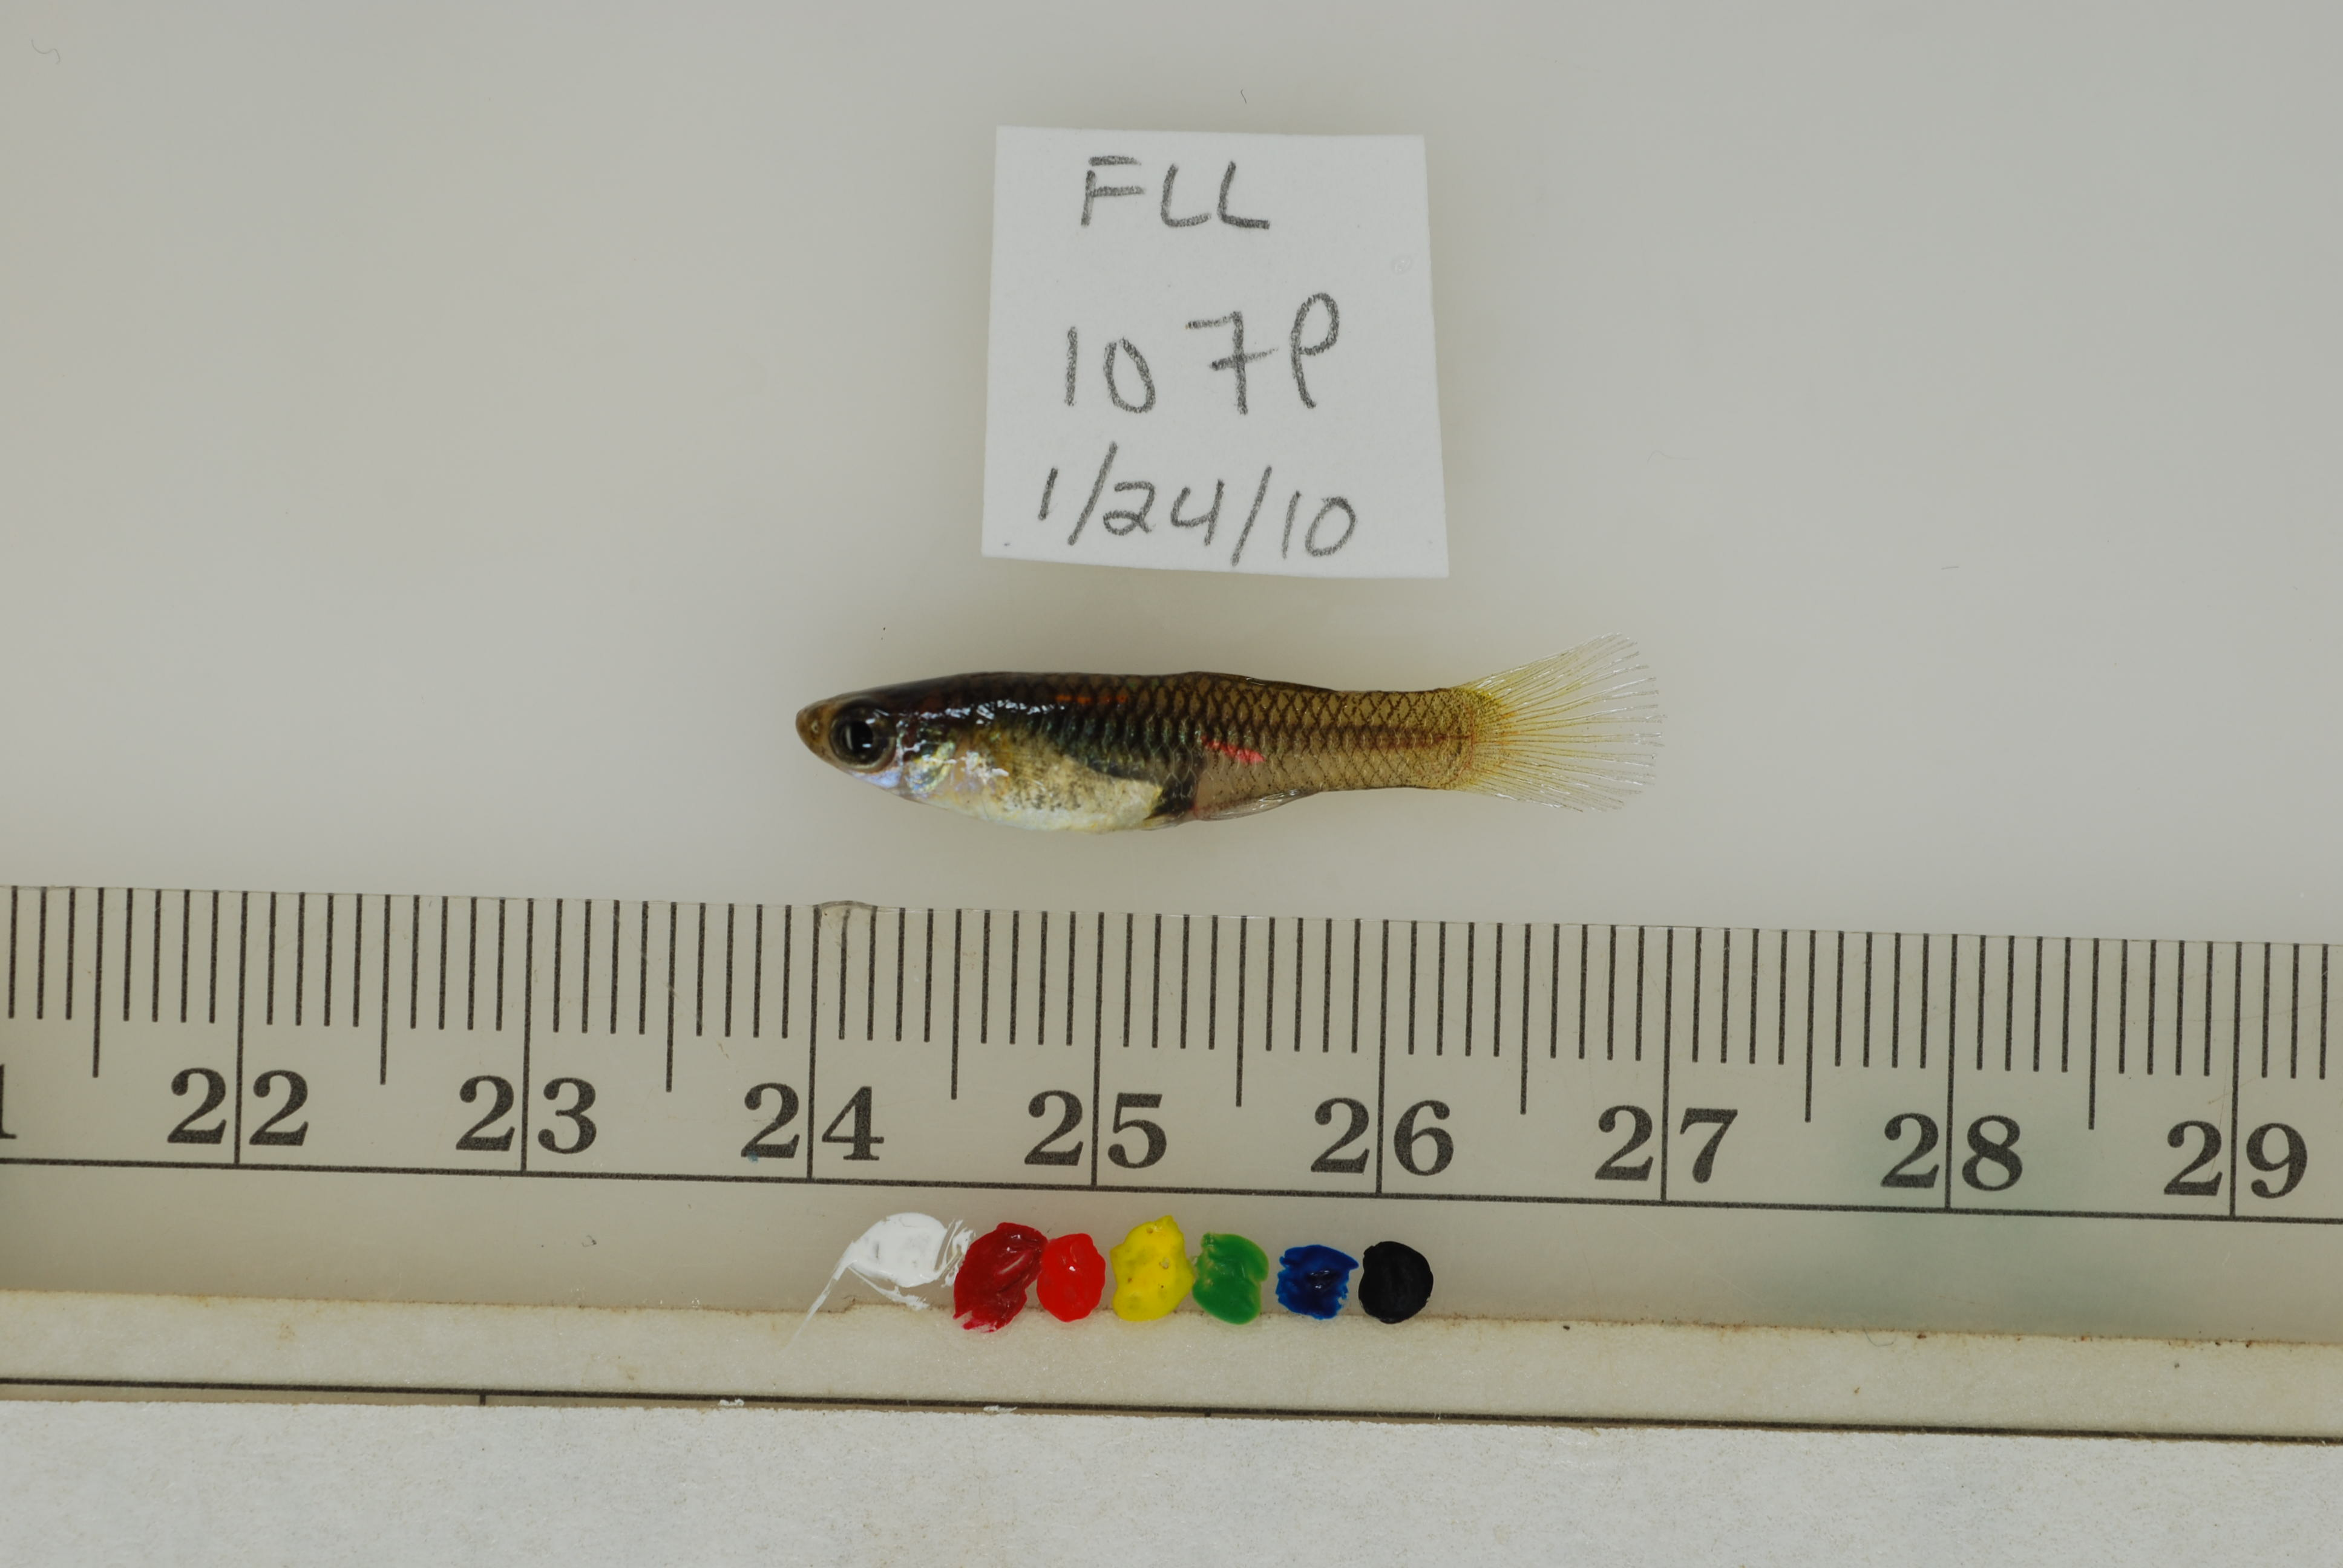

In [154]:
# file = new_files[1]
file = 'Manually_Labelled/New/LL1001/FLL1O7P1001.JPG'
# file = invalid_files[2]

result = CorrectedLabel(file, verbose=True)
image = result[0]

corrected_label = result[2]

print('\n'+file, TruthFromFileName(file), corrected_label)
Image.open(image)

## Write the results in parallel to a new file.

In [3]:
def WriteResult(file):
    with open('../Data/large_truth.csv', 'a') as f:
        writer = csv.writer(f)
        
        # Read the data and predict the label.
        image, initial_label, corrected_label, word_confidences = CorrectedLabel(file)
    
        # Provide truth
        truth = TruthFromFileName(file)

        writer.writerow([file, initial_label, corrected_label, truth])

from concurrent.futures import ThreadPoolExecutor

np.random.shuffle(new_jpg_files)

files = new_jpg_files[:100]

with ThreadPoolExecutor() as executor:
    executor.map(WriteResult, files)

In [4]:
def NewAccuracyCheck(truth_file, verbose=False):
    """Compares the corrected predictions to the truth OF THE NEW DATA SET (WHERE THE DATE IS WRITTEN IN THE INCORRECT FORMAT)
    and determines if the prediction is correct, incorrect (attempted and wrong)
    or invalide (not attempted). Characters that were confused are added to the character_confusions list."""
    correct_files = []
    probably_correct_files = []
    incorrect_files = []
    invalid_files = []

    index = []

    character_confusions = []

    with open(truth_file, 'r') as f:
        filereader = csv.reader(f)
        for n, row in enumerate(filereader):
            if row != []:
                corrected_label = row[2]
                truth = row[3]

                if corrected_label == '1':
                    invalid_files.append(row[0])
                    if verbose: print(n + 1, "Invalid")

                else:
                    split_label = corrected_label.split('-')
                    corrected_date = split_label[-1]
                    rearranged_date = corrected_date[-2] + corrected_date[-1] + '/' + corrected_date[0] + corrected_date[1]
                    split_label[-1] = rearranged_date
                    rearranged_label = "%s-%s-%s" %(str(split_label[0]), str(split_label[1]), str(split_label[2]))

                    correct = int(truth == rearranged_label)
                    if correct:
                        correct_files.append(row[0])

                    else: 
                        true = truth.split('-')
                        pred = rearranged_label.split('-')

                        if true[0] == pred[0] and true[1] == pred[1]:
                            probably_correct_files.append(row[0])

                        else:
                            incorrect_files.append(row[0])

                            print(row[0], true, pred, n + 1)

                            if len(true) != 3 or len(pred) != 3:
                                if verbose: print(n, 'error')
                                continue

                            for i in range(3):
                                if true[i] != pred[i]:
                                    if verbose: print(n + 1, true[i], pred[i])

                                    if (i == 1) and (len(true[i]) == len(pred[i])): #mistake in identity.
                                        for j in range(len(true[i])):
                                            if true[i][j] != pred[i][j]:
                                                character_confusions.append((true[i][j], pred[i][j]))




    print("\nNumber Correct:", len(correct_files), 
          "\nNumber Probably Correct:", len(probably_correct_files), 
          "\nNumber Incorrect:", len(incorrect_files),
          "\nNumber Invalid:", len(invalid_files))

    character_confusions = np.array(character_confusions)

    print("Attempted % Probably Correct:", (len(correct_files) + len(probably_correct_files)) / (len(correct_files) + len(incorrect_files) + len(probably_correct_files)))
    print("Total % Probably Correct:", (len(correct_files) + len(probably_correct_files)) / (len(correct_files) + len(incorrect_files) + len(invalid_files) + len(probably_correct_files)))

    return correct_files, incorrect_files, invalid_files, character_confusions

correct_files, incorrect_files, invalid_files, character_confusions = NewAccuracyCheck('../Data/large_truth.csv')

Manually_Labelled/New/TY1103/FTY1Y4S1103.JPG ['FTY', '1Y4S', '11/03'] ['FTY', '194S', '11/03'] 13
Manually_Labelled/New/LL1002/FLL1Y8K1002.JPG ['FLL', '1Y8K', '10/02'] ['FLL', '1Y5K', '10/02'] 17
Manually_Labelled/New/TY1201/MTY3K6B1201.JPG ['MTY', '3K6B', '12/01'] ['MTY', '3KLB', '12/01'] 23
Manually_Labelled/New/CA1002/FCA1O4P1002.JPG ['FCA', '1O4P', '10/02'] ['FCA', '1O4O', '10/02'] 37
Manually_Labelled/New/UL1004/MUL1Y3P1004.JPG ['MUL', '1Y3P', '10/04'] ['MUL', '1K3P', '10/05'] 39
Manually_Labelled/New/CA1107/FCA6Y7V1107.JPG ['FCA', '6Y7V', '11/07'] ['FCA', '6Y1V', '11/07'] 59
Manually_Labelled/New/TY1204/MTY5O6P1204.JPG ['MTY', '5O6P', '12/04'] ['MTY', '1S0G0', '12/04'] 61
Manually_Labelled/New/TY1005/Taylor B2/DCIM/100NCD60/MEASURED/FTY3V4W1005 (1).JPG ['FTY', '3V4W1', '00/5 '] ['FTY', '3V4W', '10/05'] 63
Manually_Labelled/New/UL1005/MUL1W8G1005.JPG ['MUL', '1W8G', '10/05'] ['MUL', '4W8G', '10/06'] 71
Manually_Labelled/New/UL1002/3-1-10 a DONE/MEASURED/FUL3B8R1002.JPG ['FUL', '3B

Text(0, 0.5, 'True Character')

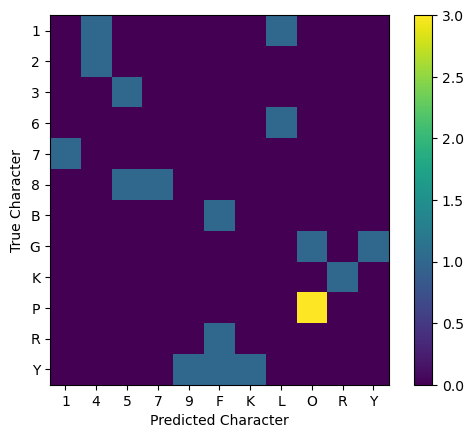

In [5]:
true_chars_unique, pred_chars_unique, confusion_matrix = \
    ConfusionMatrix(character_confusions)

import matplotlib.pyplot as plt
plt.imshow(confusion_matrix)
plt.yticks(np.arange(len(true_chars_unique)), true_chars_unique)
plt.xticks(np.arange(len(pred_chars_unique)), pred_chars_unique)
plt.colorbar()
plt.xlabel("Predicted Character")
plt.ylabel("True Character")

### *Downloads*: Downloads images from the google bucket.

In [ ]:
correct_files, incorrect_files, invalid_files

for i, file in enumerate(incorrect_files):
    # Initialise a client
    storage_client = storage.Client()
    # Create a bucket object for our bucket
    bucket = storage_client.get_bucket("guppy_images")
    # Create a blob object from the filepath
    blob = bucket.blob(file)
    # Download the file to a destination
    blob.download_to_filename('../Data/Images/IncorrectImages/%s' %(file.replace("/", "-")))
    print("%i/%i" %(i+1, len(error_files)))

for i, file in enumerate(correct_files[0:200]):
    # Initialise a client
    storage_client = storage.Client()
    # Create a bucket object for our bucket
    bucket = storage_client.get_bucket("guppy_images")
    # Create a blob object from the filepath
    blob = bucket.blob(file)
    # Download the file to a destination
    blob.download_to_filename('../Data/Images/CorrectImages/%s' %(file.replace("/", "-")))
    print("%i/%i" %(i+1, len(correct_subset)))

for i, file in enumerate(invalid_files):
    # Initialise a client
    storage_client = storage.Client()
    # Create a bucket object for our bucket
    bucket = storage_client.get_bucket("guppy_images")
    # Create a blob object from the filepath
    blob = bucket.blob(file)
    # Download the file to a destination
    blob.download_to_filename('../Data/Images/InvalidImages/%s' %(file.replace("/", "-")))
    print("%i/%i" %(i+1, len(correct_subset)))

### *Interactive*: Write the filename, initial prediction, corrected prediction and the manually inputted truth to the truth.csv file for a set of file names.

In [ ]:
# Read all JPG files. All images are in both .jpg and .nef formats, need to avoid duplicates.
all_files = ListAvaliableFiles("guppy_images")
all_jpg_files = [ x for x in all_files if "JPG" in x ]

# Read the random number array we will use to assign images.
# random_array = np.arange(len(all_jpg_files))
# np.random.shuffle(random_array)
# np.save('../Data/radom_array.npy', random_array)
random_array = np.load('../Data/radom_array.npy')

# Assign images.
Jordan_array = random_array[0:500]
Sunny_array = random_array[500:1000]

Jordan_files = []
Sunny_files = []

for index in Jordan_array:
    Jordan_files.append(all_jpg_files[index])

for index in Sunny_array:
    Sunny_files.append(all_jpg_files[index])

In [ ]:
with open('../Data/truth.csv', 'a') as f:
    writer = csv.writer(f)

    for file in Sunny_files:
        # Read the data and predict the label.
        image = RetreiveImage(file, verbose=False)
        cropped_image = CroppedImage(image, verbose=False)

        display.display(Image.open(cropped_image))
        display.clear_output(wait=True)

        initial_prediction = ReadImage(cropped_image, verbose=False)[0]
        corrected_prediction = FindErrors(initial_prediction)
    
        # Provide truth
        truth = input("Truth:")

        writer.writerow([file, initial_prediction, corrected_prediction, truth])

### Code used to combine truth_sunny and truth_Jordan files.

In [ ]:
# files = ['../Data/truth_Jordan.csv', '../Data/truth_sunny.csv']

# whole_file = []

# for file in files:
#     with open(file, 'r') as f:
#         filereader = csv.reader(f)
#         for row in filereader:
#             if row != []:
#                 whole_file.append(row)


# with open('../Data/Truth.csv', 'w') as Truth:
#     writer = csv.writer(Truth)
#     for row in whole_file:
#         writer.writerow(row)